In [15]:
import keras
from keras import layers
#import tensorflow as tf
import tensorflow.compat.v1 as tf
import os
from IPython.display import Audio, display
import numpy as np
import matplotlib.pyplot as plt
import librosa
import scipy.optimize as scopt

tf.disable_v2_behavior()

## Chargement des fichiers

In [3]:
fichier_cible = "fichier_cible.mp3"
fichier_style = "fichier_style.mp3"

In [4]:
display(Audio(fichier_cible))
display(Audio(fichier_style))

In [5]:
N_FFT = 2048
def read_audio_spectum(filename):
    x, fs = librosa.load(filename)
    S = librosa.stft(x, N_FFT)
    p = np.angle(S)
    
    S = np.log1p(np.abs(S[:,:430]))  
    return S, fs

In [6]:
a_content, fs = read_audio_spectum(fichier_cible)
a_style, fs = read_audio_spectum(fichier_style)

N_SAMPLES = a_content.shape[1]
N_CHANNELS = a_content.shape[0]
a_style = a_style[:N_CHANNELS, :N_SAMPLES]

/home/mamdadou/miniconda3/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/home/mamdadou/miniconda3/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


## Visualisation des spectrogrammes

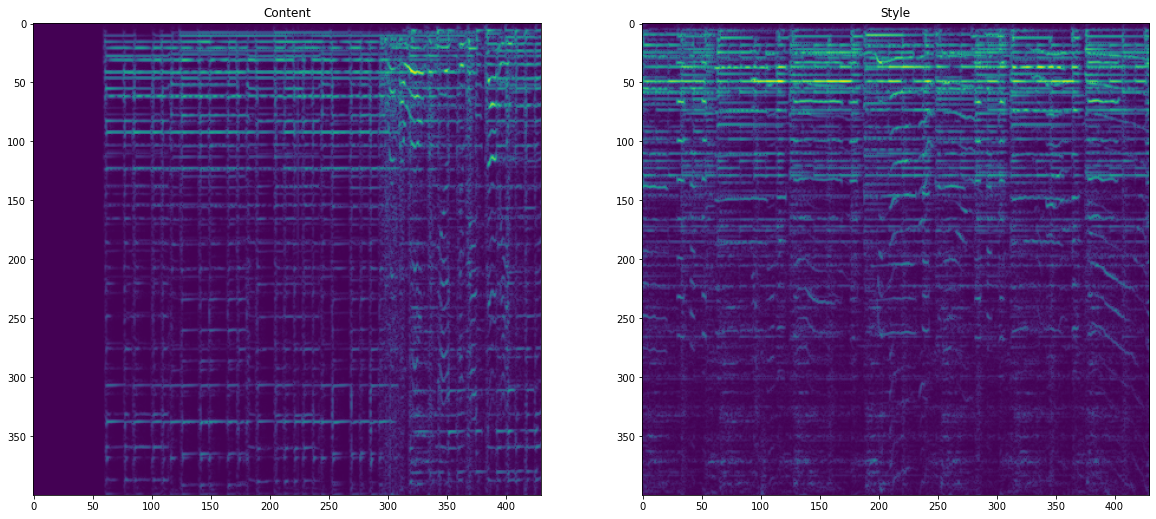

In [7]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.title('Content')
plt.imshow(a_content[:400,:])
plt.subplot(1, 2, 2)
plt.title('Style')
plt.imshow(a_style[:400,:])
plt.show()

## Tentative de calcul

In [8]:
N_FILTERS = 4096

a_content_tf = np.ascontiguousarray(a_content.T[None,None,:,:])
a_style_tf = np.ascontiguousarray(a_style.T[None,None,:,:])

# filter shape is "[filter_height, filter_width, in_channels, out_channels]"
std = np.sqrt(2) * np.sqrt(2.0 / ((N_CHANNELS + N_FILTERS) * 11))
kernel = np.random.randn(1, 11, N_CHANNELS, N_FILTERS)*std
    
g = tf.Graph()
with g.as_default(), g.device('/cpu:0'), tf.compat.v1.Session() as sess:
    # data shape is "[batch, in_height, in_width, in_channels]",
    x = tf.placeholder('float32', [1,1,N_SAMPLES,N_CHANNELS], name="x")

    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    conv = tf.nn.conv2d(
        x,
        kernel_tf,
        strides=[1, 1, 1, 1],
        padding="VALID",
        name="conv")
    
    net = tf.nn.relu(conv)

    content_features = net.eval(feed_dict={x: a_content_tf})
    style_features = net.eval(feed_dict={x: a_style_tf})
    
    features = np.reshape(style_features, (-1, N_FILTERS))
    style_gram = np.matmul(features.T, features) / N_SAMPLES

## Tentative d'optimisation

In [22]:
from sys import stderr

ALPHA= 1e-2
learning_rate= 1e-5
iterations = 10000

result = None
with tf.Graph().as_default():

    # Build graph with variable input
    x = tf.Variable(np.zeros([1,1,N_SAMPLES,N_CHANNELS], dtype=np.float32), name="x")
    x = tf.Variable(np.random.randn(1,1,N_SAMPLES,N_CHANNELS).astype(np.float32)*1e-3, name="x")

    kernel_tf = tf.constant(kernel, name="kernel", dtype='float32')
    conv = tf.nn.conv2d(
        x,
        kernel_tf,
        strides=[1, 1, 1, 1],
        padding="VALID",
        name="conv")
    
    
    net = tf.nn.relu(conv)

    content_loss = ALPHA * 2 * tf.nn.l2_loss(
            net - content_features)

    style_loss = 0

    _, height, width, number = map(lambda i: i.value, net.get_shape())

    size = height * width * number
    feats = tf.reshape(net, (-1, number))
    gram = tf.matmul(tf.transpose(feats), feats)  / N_SAMPLES
    style_loss = 2 * tf.nn.l2_loss(gram - style_gram)

     # Overall loss
    loss = content_loss + style_loss

    #opt = tf.contrib.opt.ScipyOptimizerInterface(
          #loss, method='L-BFGS-B', options={'maxiter': 300})
        
    # Optimization
#     with tf.Session() as sess:
#         sess.run(tf.initialize_all_variables())
       
#         print('Started optimization.')
#         #opt.minimize(sess)
    
#         print('Final loss:', loss.eval())
#         result = x.eval()
    
    #Autre approche d'optimisation
    def model(x) :
        return tf.reduce_sum(tf.square(x-tf.constant(2,dtype=tf.float32)))
    
    @tf.function
    
    def val_and_grad(x) :
        with tf.GradientTape() as tape:
            tape.watch(x)
            loss = model(x)
        grad = tape.gradient(loss,x)
        return loss, grad
    
    def func(x) :
        return [vv.numpy().astype(np.float64) for vv in val_and_grad(tf.constant(x,dtype=tf.float32))]
    
    resdd = scopt.minimize(fun=func, x0=np.ones(5), jac=True)
    print("info  :  \n",resdd)

AttributeError: 'Tensor' object has no attribute 'numpy'